In [1]:
import pandas as pd
from sqlalchemy import text
from google.cloud import bigquery

import matplotlib.pyplot as plt

# Uses Application Default Credentials (run `gcloud auth application-default login` first)
bq_client = bigquery.Client(project="prizepicksanalytics")


In [2]:
tennis_stat_type_query = """
select distinct stat_type_name, stat_type_id from `prizepicksanalytics.pick_level.pick_level` where league_name = 'TENNIS'"""
df = bq_client.query(tennis_stat_type_query).to_dataframe()
df


,stat_type_name,stat_type_id
0,Total Games Lost,845
1,Break Points Won,103
2,Matches Won,84
3,Total Tie Breaks,1012
4,Total Games Won,63
5,Aces,61
6,Double Faults,864
7,Total Games,62
8,Total Sets,64
9,Fantasy Score,14


In [3]:
tennis_games_won = """
   WITH RankedPicks AS (
    SELECT
      *,
      ROW_NUMBER() OVER(
        PARTITION BY 
          overall_league, 
          description, 
          stat_type_id, 
          league_name, 
          player_name, 
          CAST(pred_line_score AS STRING), 
          stat_type_name, 
          outcome_was_over, 
          outcome_was_under, 
          CAST(score AS STRING)
        ORDER BY 
          created_at_est DESC
      ) as rn
    FROM
      `prizepicksanalytics.pick_level.pick_level`
    WHERE
      overall_league IN ('TENNIS')
      AND league_name IN ('TENNIS')
      AND stat_type_id IN (63)
      AND NOT demon_pick 
      AND NOT goblin_pick
      AND NOT is_off_the_board
      AND was_refunded_cancelled = 0
  )
  SELECT
      overall_league,
      created_at_est,
      description,
      stat_type_id,
      league_name,
      player_name,
      pred_line_score,
      stat_type_name,
      outcome_was_over,
      outcome_was_under,
      score
  FROM
      RankedPicks
  WHERE
      rn = 1
      """

In [4]:
# Fetch fantasy score actuals from BigQuery
df = bq_client.query(tennis_games_won).to_dataframe()

# Drop any super old picks
df = df[df.created_at_est > "2020-01-01"]
df.head()

,overall_league,created_at_est,description,stat_type_id,league_name,player_name,pred_line_score,stat_type_name,outcome_was_over,outcome_was_under,score
0,TENNIS,2026-01-21 23:44:59.303191+00:00,Arthur Gea,63,TENNIS,Stan Wawrinka,19.5,Total Games Won,1,0,27.0
1,TENNIS,2026-02-01 18:19:15.598741+00:00,Cristina Bucsa,63,TENNIS,Sonay Kartal,12.5,Total Games Won,0,0,0.0
2,TENNIS,2025-11-17 21:09:48.315954+00:00,Kaylan Bigun,63,TENNIS,Elias Ymer,12.5,Total Games Won,0,1,0.0
3,TENNIS,2025-08-27 11:00:00.845812+00:00,Jerome Kym,63,TENNIS,Brandon Nakashima,20.5,Total Games Won,1,0,29.0
4,TENNIS,2025-07-05 08:00:01.152069+00:00,Brandon Nakashima,63,TENNIS,Lorenzo Sonego,19.5,Total Games Won,1,0,30.0


In [41]:
def assign_segment(line):
    if line <= 7.5:
        return "Bo3_lopsided"
    elif line <= 12.0:
        return "Bo3_underdog"
    elif line <= 13.0:
        return "Bo3_competitive"
    elif line <= 18.5:
        return "Ambiguous"
    else:
        return "Bo5_likely"

df["segment"] = df["pred_line_score"].apply(assign_segment)

In [42]:
# Calculate statistics for each segment
segment_stats = df.groupby("segment").agg(
    count=("score", "count"),
    mean_line=("pred_line_score", "mean"),
    mean_actual=("score", "mean"),
    std_actual=("score", "std"),
    min_line=("pred_line_score", "min"),
    max_line=("pred_line_score", "max"),
    min_actual=("score", "min"),
    max_actual=("score", "max"),
).round(2)

print("Segment Statistics:")
print(segment_stats.to_string())

# Distribution of segments
print(f"\nSegment Distribution:")
print(df["segment"].value_counts())

Segment Statistics:
                 count  mean_line  mean_actual  std_actual  min_line  max_line  min_actual  max_actual
segment                                                                                               
Ambiguous          400      16.14        16.06        6.51      13.5      18.5         1.0        33.0
Bo3_competitive   3451      12.62        12.35        4.18      12.5      13.0         0.0       130.0
Bo3_lopsided       437       6.58         7.17        4.19       0.5       7.5         0.0        20.0
Bo3_underdog      2625      10.70        10.23        4.91       8.0      12.0         0.0       130.0
Bo5_likely         826      20.37        19.83        5.38      19.0      31.5         2.0        32.0

Segment Distribution:
segment
Bo3_competitive    3451
Bo3_underdog       2625
Bo5_likely          826
Bo3_lopsided        437
Ambiguous           400
Name: count, dtype: int64


In [43]:
import numpy as np
from scipy import stats
def compute_calibration(df_segment, segment_name, std_override=None):
    """
    Compute calibration metrics for a segment.
    For each pick, we create a normal distribution centered at pred_line_score 
    with the segment's std, then check what percentile the actual score falls at.
    """
    if len(df_segment) < 10:
        return None
    
    # Use segment's empirical std or override
    segment_std = std_override if std_override else df_segment["score"].std()
    
    percentiles = []
    for _, row in df_segment.iterrows():
        # Create normal distribution centered at the predicted line
        dist = stats.norm(loc=row["pred_line_score"], scale=segment_std)
        # Find what percentile the actual score falls at
        percentile = dist.cdf(row["score"])
        percentiles.append(percentile)
    
    return np.array(percentiles)

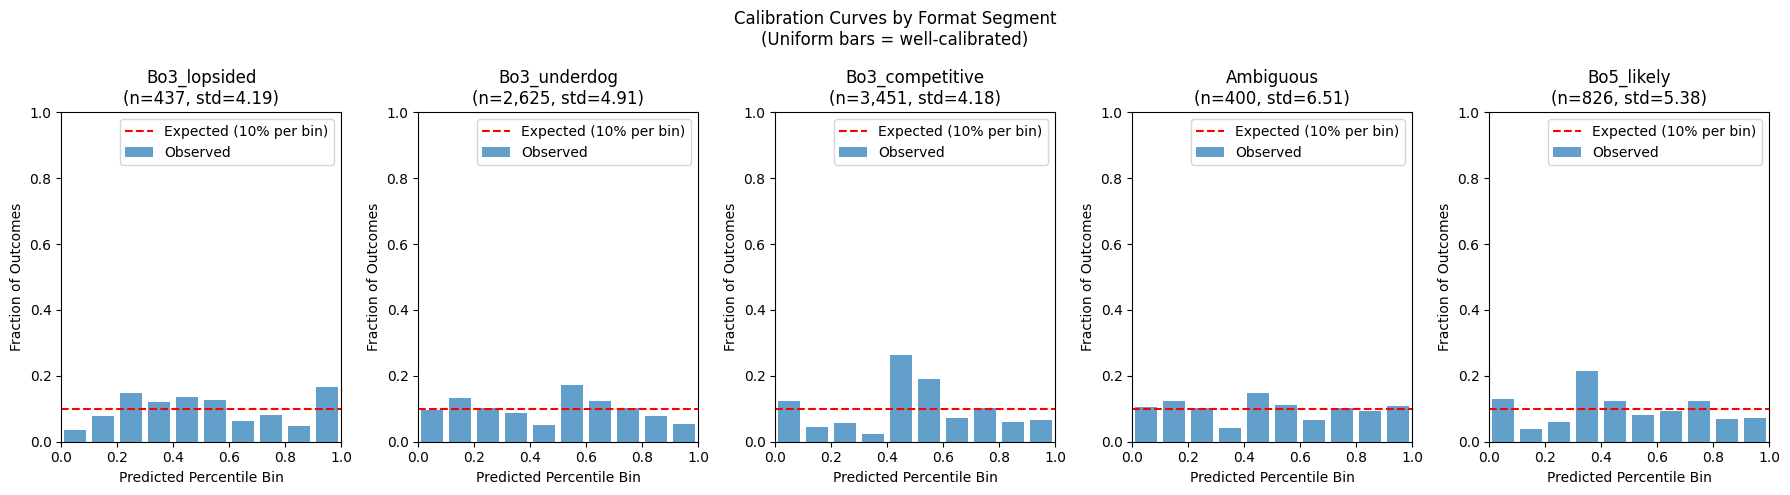

In [53]:
def plot_calibration_curve(percentiles, segment_name, ax):
    """
    Plot calibration curve: expected percentiles vs observed frequency.
    A well-calibrated model has points along the diagonal.
    """
    # Define bins for percentiles
    bins = np.linspace(0, 1, 11)  # 0, 0.1, 0.2, ..., 1.0
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate observed frequency for each bin
    observed_freq = []
    for i in range(len(bins) - 1):
        in_bin = (percentiles >= bins[i]) & (percentiles < bins[i+1])
        observed_freq.append(in_bin.mean())
    
    # Plot
    ax.bar(bin_centers, observed_freq, width=0.08, alpha=0.7, label="Observed")
    ax.plot([0, 1], [0.1, 0.1], 'r--', label="Expected (10% per bin)")
    ax.set_xlabel("Predicted Percentile Bin")
    ax.set_ylabel("Fraction of Outcomes")
    ax.set_title(f"{segment_name}\n(n={len(percentiles):,}, std={df[df['segment']==segment_name]['score'].std():.2f})")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)  # Cap y-axis at 100%
    ax.legend()
    
    return observed_freq


# Plot calibration curves for each segment
segments = ["Bo3_lopsided", "Bo3_underdog", "Bo3_competitive", "Ambiguous", "Bo5_likely"]
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

calibration_results = {}
for ax, segment in zip(axes, segments):
    df_seg = df[df["segment"] == segment]
    if len(df_seg) >= 10:
        percentiles = compute_calibration(df_seg, segment)
        calibration_results[segment] = percentiles
        plot_calibration_curve(percentiles, segment, ax)
    else:
        ax.set_title(f"{segment}\n(insufficient data)")

fig.suptitle("Calibration Curves by Format Segment\n(Uniform bars = well-calibrated)", fontsize=12)
plt.tight_layout()
plt.show()

_______

In [54]:
# Quantitative Calibration Metrics
# Key metrics:
# 1. Coverage: What % of actuals fall within predicted 80% interval (10th-90th percentile)?
# 2. Calibration Error: How far off are the observed percentile frequencies from expected?

def compute_calibration_metrics(percentiles, segment_name):
    """Compute quantitative calibration metrics."""
    
    # Coverage metrics
    coverage_50 = ((percentiles >= 0.25) & (percentiles <= 0.75)).mean()  # 50% interval
    coverage_80 = ((percentiles >= 0.10) & (percentiles <= 0.90)).mean()  # 80% interval
    coverage_95 = ((percentiles >= 0.025) & (percentiles <= 0.975)).mean()  # 95% interval
    
    # Mean Absolute Calibration Error (MACE)
    # For a well-calibrated model, percentiles should be uniform [0,1]
    # Check if each decile has ~10% of outcomes
    bins = np.linspace(0, 1, 11)
    observed_freq = []
    for i in range(len(bins) - 1):
        in_bin = (percentiles >= bins[i]) & (percentiles < bins[i+1])
        observed_freq.append(in_bin.mean())
    
    expected_freq = 0.1  # Each bin should have 10%
    mace = np.mean(np.abs(np.array(observed_freq) - expected_freq))
    
    # Check for systematic bias (are we over/under predicting?)
    median_percentile = np.median(percentiles)  # Should be ~0.5 if well-calibrated
    
    return {
        "segment": segment_name,
        "n": len(percentiles),
        "coverage_50": f"{coverage_50:.1%}",
        "coverage_80": f"{coverage_80:.1%}",
        "coverage_95": f"{coverage_95:.1%}",
        "mace": f"{mace:.3f}",
        "median_percentile": f"{median_percentile:.2f}",
        "interpretation": "over-predicting" if median_percentile > 0.55 else "under-predicting" if median_percentile < 0.45 else "balanced"
    }

# Compute metrics for each segment
print("Calibration Metrics by Segment:")
print("=" * 80)
print(f"{'Segment':<15} {'N':>8} {'Cov50%':>10} {'Cov80%':>10} {'Cov95%':>10} {'MACE':>8} {'Med%ile':>10} {'Bias':>15}")
print("-" * 80)

for segment in segments:
    if segment in calibration_results:
        metrics = compute_calibration_metrics(calibration_results[segment], segment)
        print(f"{metrics['segment']:<15} {metrics['n']:>8} {metrics['coverage_50']:>10} {metrics['coverage_80']:>10} {metrics['coverage_95']:>10} {metrics['mace']:>8} {metrics['median_percentile']:>10} {metrics['interpretation']:>15}")

print("-" * 80)
print("""
Interpretation Guide:
- Coverage 50%: Should be ~50% (% of actuals in 25th-75th percentile)
- Coverage 80%: Should be ~80% (% of actuals in 10th-90th percentile)  
- Coverage 95%: Should be ~95% (% of actuals in 2.5th-97.5th percentile)
- MACE: Lower is better (0 = perfect calibration)
- Median Percentile: Should be ~0.50 (0.50 = no bias, >0.5 = over-predicting, <0.5 = under-predicting)
""")

Calibration Metrics by Segment:
Segment                N     Cov50%     Cov80%     Cov95%     MACE    Med%ile            Bias
--------------------------------------------------------------------------------
Bo3_lopsided         437      53.1%      79.9%      94.1%    0.039       0.45        balanced
Bo3_underdog        2625      50.2%      85.0%      98.2%    0.027       0.50        balanced
Bo3_competitive     3451      61.2%      81.0%      96.7%    0.055       0.45        balanced
Ambiguous            400      45.5%      78.8%      96.5%    0.020       0.47        balanced
Bo5_likely           826      60.4%      79.8%      95.6%    0.038       0.46        balanced
--------------------------------------------------------------------------------

Interpretation Guide:
- Coverage 50%: Should be ~50% (% of actuals in 25th-75th percentile)
- Coverage 80%: Should be ~80% (% of actuals in 10th-90th percentile)  
- Coverage 95%: Should be ~95% (% of actuals in 2.5th-97.5th percentile)
- MA

  Max score in data: 130.0


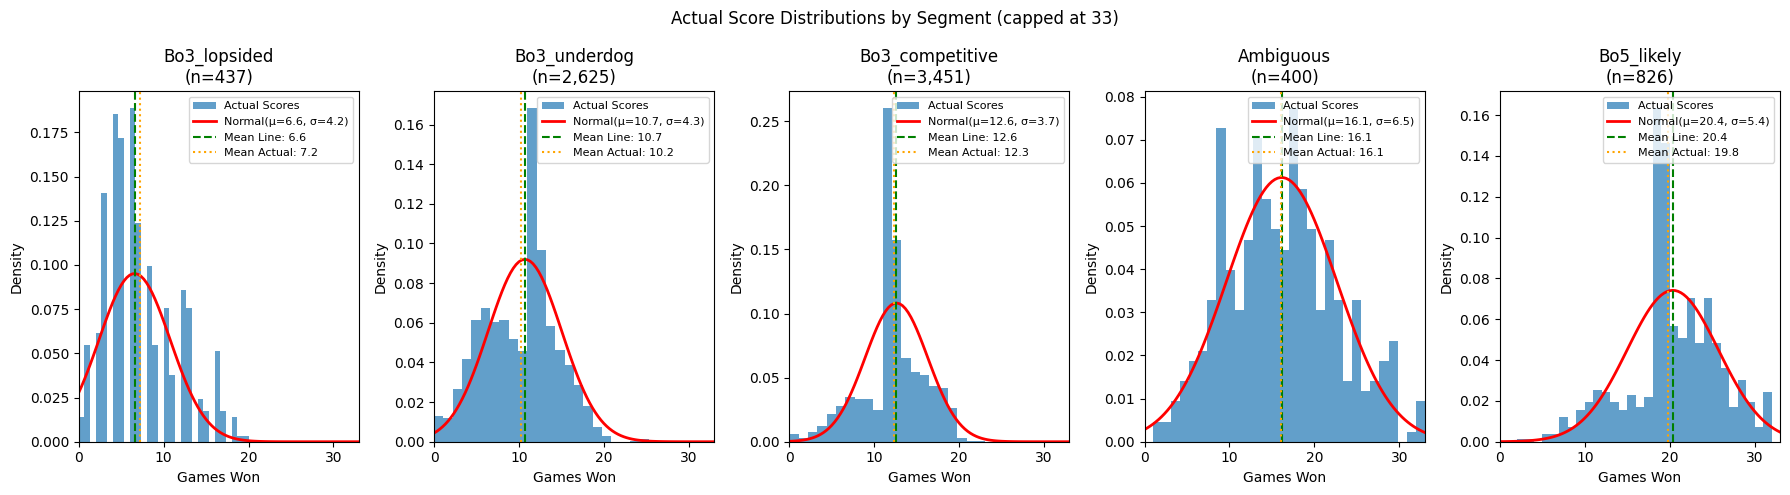

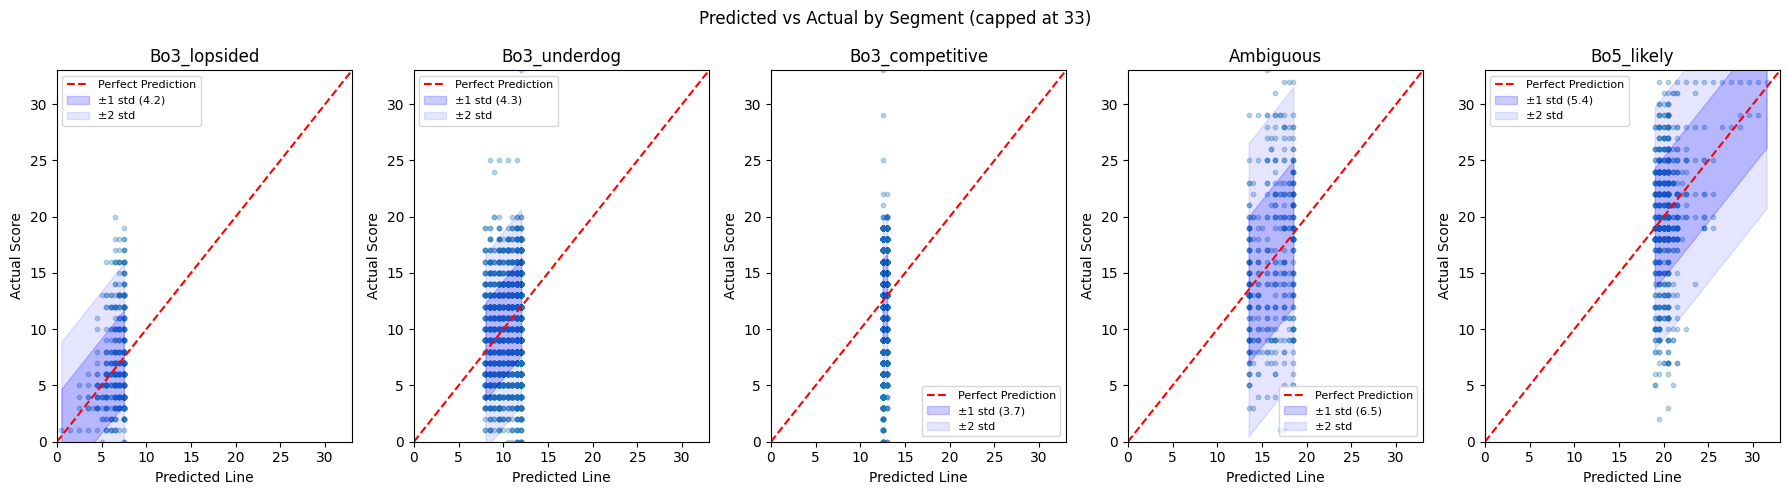

In [55]:
# Visualize actual score distributions by segment
# This helps verify if the segments have meaningfully different characteristics
# Cap at 33 games (max possible in BO5)

SCORE_CAP = 33

# Check for bad data above cap
bad_data = df[df["score"] > SCORE_CAP]
if len(bad_data) > 0:
    print(f"WARNING: {len(bad_data)} records with score > {SCORE_CAP} (likely bad data)")
    print(f"  Max score in data: {df['score'].max()}")

fig, axes = plt.subplots(1, 5, figsize=(18, 5))

for ax, segment in zip(axes, segments):
    df_seg = df[df["segment"] == segment]
    if len(df_seg) >= 10:
        # Cap scores at 33 for plotting
        scores_capped = df_seg["score"].clip(upper=SCORE_CAP)
        
        # Plot actual scores
        ax.hist(scores_capped, bins=30, density=True, alpha=0.7, label="Actual Scores")
        
        # Overlay the fitted normal distribution
        segment_mean = df_seg["pred_line_score"].mean()
        segment_std = scores_capped.std()
        x = np.linspace(0, SCORE_CAP, 100)
        ax.plot(x, stats.norm.pdf(x, segment_mean, segment_std), 'r-', lw=2, 
                label=f"Normal(μ={segment_mean:.1f}, σ={segment_std:.1f})")
        
        ax.axvline(segment_mean, color='green', linestyle='--', label=f"Mean Line: {segment_mean:.1f}")
        ax.axvline(scores_capped.mean(), color='orange', linestyle=':', label=f"Mean Actual: {scores_capped.mean():.1f}")
        
        ax.set_xlabel("Games Won")
        ax.set_ylabel("Density")
        ax.set_xlim(0, SCORE_CAP)
        ax.set_title(f"{segment}\n(n={len(df_seg):,})")
        ax.legend(fontsize=8)

fig.suptitle("Actual Score Distributions by Segment (capped at 33)", fontsize=12)
plt.tight_layout()
plt.show()

# Also show the relationship between predicted line and actual score
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

for ax, segment in zip(axes, segments):
    df_seg = df[df["segment"] == segment]
    if len(df_seg) >= 10:
        # Cap scores at 33 for plotting
        scores_capped = df_seg["score"].clip(upper=SCORE_CAP)
        
        ax.scatter(df_seg["pred_line_score"], scores_capped, alpha=0.3, s=10)
        
        # Perfect prediction line
        min_val = min(df_seg["pred_line_score"].min(), 0)
        max_val = SCORE_CAP
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
        
        # Add std bands
        segment_std = scores_capped.std()
        x_line = np.linspace(df_seg["pred_line_score"].min(), df_seg["pred_line_score"].max(), 100)
        ax.fill_between(x_line, x_line - segment_std, x_line + segment_std, alpha=0.2, color='blue', label=f"±1 std ({segment_std:.1f})")
        ax.fill_between(x_line, x_line - 2*segment_std, x_line + 2*segment_std, alpha=0.1, color='blue', label=f"±2 std")
        
        ax.set_xlabel("Predicted Line")
        ax.set_ylabel("Actual Score")
        ax.set_xlim(0, SCORE_CAP)
        ax.set_ylim(0, SCORE_CAP)
        ax.set_title(f"{segment}")
        ax.legend(fontsize=8)

fig.suptitle("Predicted vs Actual by Segment (capped at 33)", fontsize=12)
plt.tight_layout()
plt.show()

Lines with 20+ observations: 29
Range: 4.5 to 21.5


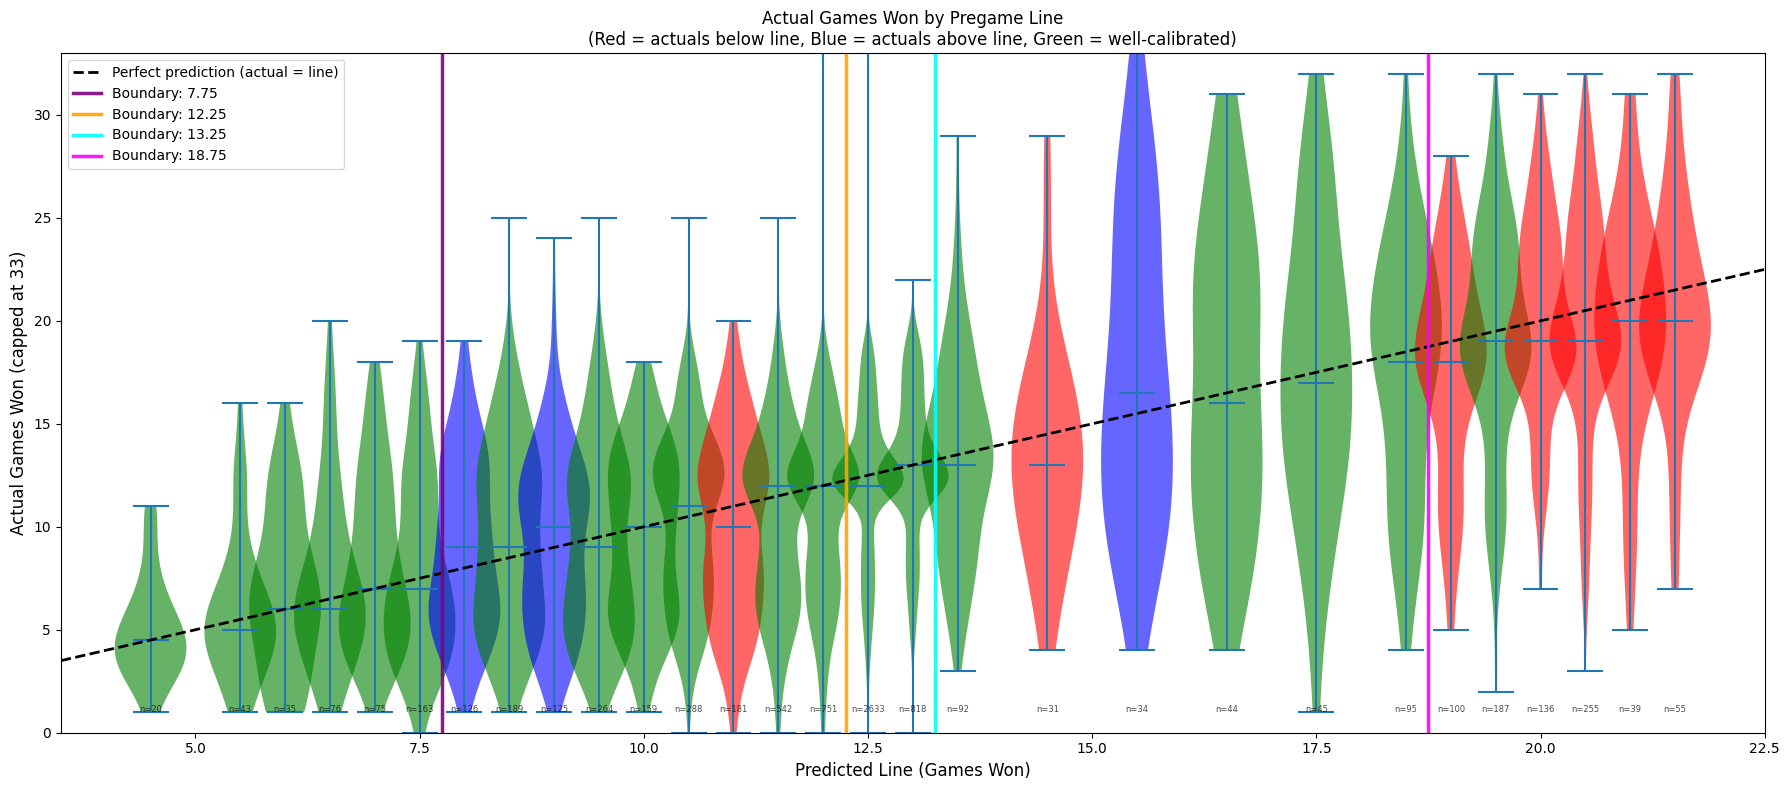


Summary by line:
  Line      n     Mean   Median      Std     Diff
--------------------------------------------------
   4.5     20     5.00      4.5     2.41    +0.50
   5.5     43     5.91      5.0     3.36    +0.41
   6.0     35     6.80      6.0     3.91    +0.80
   6.5     76     7.39      6.0     4.21    +0.89
   7.0     75     8.12      7.0     4.13    +1.12
   7.5    163     7.86      7.0     4.38    +0.36
   8.0    126     8.97      9.0     4.21    +0.97
   8.5    189     9.39      9.0     4.56    +0.89
   9.0    125     9.36     10.0     4.30    +0.36
   9.5    264     9.21      9.0     4.55    -0.29
  10.0    159     9.58     10.0     4.08    -0.42
  10.5    288    10.38     11.0     4.13    -0.12
  11.0    181    10.08     10.0     4.38    -0.92
  11.5    542    10.47     12.0     4.26    -1.03
  12.0    751    10.96     12.0     4.22    -1.04
  12.5   2633    12.15     12.0     3.73    -0.35
  13.0    818    12.87     13.0     3.48    -0.13
  13.5     92    13.39     13.0

In [31]:
# Violin plots for all lines - RAW ACTUAL GAMES (capped at 33)
# No bucket dependency - shows true outcome distributions

line_counts = df["pred_line_score"].value_counts()
lines_with_data = line_counts[line_counts >= 20].index.sort_values()
print(f"Lines with 20+ observations: {len(lines_with_data)}")
print(f"Range: {lines_with_data.min()} to {lines_with_data.max()}")

# Prepare data for violin plot
violin_data = []
positions = []
for line in lines_with_data:
    line_df = df[df["pred_line_score"] == line]
    # Cap scores at 33
    violin_data.append(line_df["score"].clip(upper=33).dropna().values)
    positions.append(line)

# Create the plot
fig, ax = plt.subplots(figsize=(18, 8))

parts = ax.violinplot(violin_data, positions=positions, widths=0.8, showmedians=True)

# Color violins by whether median is above or below the line
for i, pc in enumerate(parts['bodies']):
    line_val = positions[i]
    median_actual = np.median(violin_data[i])
    diff = median_actual - line_val
    if diff < -0.5:  # Actuals below line by more than 0.5 games
        pc.set_facecolor('red')
        pc.set_alpha(0.6)
    elif diff > 0.5:  # Actuals above line by more than 0.5 games
        pc.set_facecolor('blue')
        pc.set_alpha(0.6)
    else:  # Within 0.5 games
        pc.set_facecolor('green')
        pc.set_alpha(0.6)

# Plot the "perfect prediction" diagonal line (where actual = predicted)
ax.plot([min(positions)-1, max(positions)+1], [min(positions)-1, max(positions)+1], 
        'k--', linewidth=2, label='Perfect prediction (actual = line)')

ax.set_xlabel("Predicted Line (Games Won)", fontsize=12)
ax.set_ylabel("Actual Games Won (capped at 33)", fontsize=12)
ax.set_title("Actual Games Won by Pregame Line\n(Red = actuals below line, Blue = actuals above line, Green = well-calibrated)", fontsize=12)
ax.set_ylim(0, 33)
ax.set_xlim(min(positions)-1, max(positions)+1)

# Add vertical lines at potential segmentation boundaries
segment_boundaries = [7.75, 12.25, 13.25, 18.75]
boundary_colors = ['purple', 'orange', 'cyan', 'magenta']
boundary_labels = ['7.75', '12.25', '13.25', '18.75']
for boundary, color, label in zip(segment_boundaries, boundary_colors, boundary_labels):
    ax.axvline(boundary, color=color, linestyle='-', linewidth=2.5, alpha=0.9, label=f'Boundary: {label}')

# Add count and std annotations
for i, line in enumerate(positions):
    n = len(violin_data[i])
    std = np.std(violin_data[i])
    ax.annotate(f'n={n}', (line, 1), ha='center', fontsize=6, alpha=0.7)

ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Also print summary stats
print("\nSummary by line:")
print(f"{'Line':>6} {'n':>6} {'Mean':>8} {'Median':>8} {'Std':>8} {'Diff':>8}")
print("-" * 50)
for i, line in enumerate(positions):
    data = violin_data[i]
    diff = np.mean(data) - line
    print(f"{line:>6.1f} {len(data):>6} {np.mean(data):>8.2f} {np.median(data):>8.1f} {np.std(data):>8.2f} {diff:>+8.2f}")

# Segment summary based on proposed boundaries
print("\n" + "=" * 60)
print("SEGMENT SUMMARY (based on proposed boundaries)")
print("=" * 60)
proposed_segments = [
    ("Seg 1: ≤7.5", 0, 7.75),
    ("Seg 2: 8-12", 7.75, 12.25),
    ("Seg 3: 12.5-13", 12.25, 13.25),
    ("Seg 4: 13.5-18.5", 13.25, 18.75),
    ("Seg 5: ≥19", 18.75, 100),
]
print(f"{'Segment':<20} {'n':>8} {'Mean':>10} {'Median':>10} {'Std':>10} {'Diff':>10}")
print("-" * 68)
for name, low, high in proposed_segments:
    seg_df = df[(df["pred_line_score"] > low) & (df["pred_line_score"] <= high)]
    if len(seg_df) > 0:
        diff = seg_df['score'].mean() - seg_df['pred_line_score'].mean()
        print(f"{name:<20} {len(seg_df):>8} {seg_df['score'].mean():>10.2f} {seg_df['score'].median():>10.1f} {seg_df['score'].std():>10.2f} {diff:>+10.2f}")

________